In [1]:
import os, gc, random
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm
from time import time, ctime

from sklearn.model_selection import KFold, GroupKFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim import Adam, AdamW
from torch.cuda.amp import autocast, GradScaler

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr, softmax

In [2]:
BRAIN_ACTIVITY = ['seizure', 'lpd', 'gpd', 'lrda', 'grda', 'other']
TARGETS = [f"{lb}_vote" for lb in BRAIN_ACTIVITY]
TARGETS_PRED = [f"{lb}_pred" for lb in BRAIN_ACTIVITY]


In [3]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv, select_fold=None):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    
    if select_fold is not None:
        oof_df = oof_df[oof_df['fold']==select_fold]
    
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

CSV Path:  ./outputs/ResnetGRU_v2_test/resnet_vstack_cv040/ResnetGRU_v2_test_oof_1.csv
Kaggle Score:  0.6632412663939226
Average KL Loss:  0.6632412
Average Prediction Entropy:  0.9407575


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,...,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,751790,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,618728447,908.0,908.0,...,0,0.034047,0.101245,0.854153,0.001645,0.002442,0.006468,2,2,0.157645
1,2366870,0.0,0.333333,0.000000,0.000000,0.000000,0.666667,1232582129,0.0,30.0,...,0,0.047431,0.090815,0.033381,0.082491,0.151701,0.594181,5,5,0.510178
2,2482631,0.0,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,...,0,0.041771,0.007426,0.035036,0.025055,0.818715,0.071998,4,5,1.485223
3,2521897,0.0,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,...,0,0.065061,0.017603,0.037840,0.038830,0.476708,0.363958,4,5,0.168959
4,3108700,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,223960986,0.0,0.0,...,0,0.071594,0.020766,0.011383,0.010661,0.010169,0.875427,5,5,0.133043


target
GPD        0.583415
GRDA       0.799372
LPD        0.593971
LRDA       1.174319
Other      0.450868
Seizure    0.964219
Name: kl_loss, dtype: float32


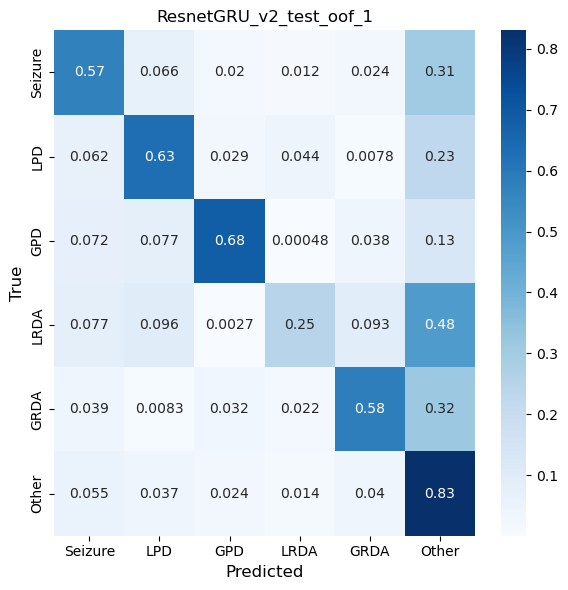

In [4]:
csv_path = './outputs/ResnetGRU_v2_test/resnet_vstack_cv040/ResnetGRU_v2_test_oof_1.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path, select_fold=None)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

pred_entropy = oof_df[TARGETS_PRED].apply(lambda x: entropy(x), axis=1)
print("Average Prediction Entropy: ", pred_entropy.mean())

display(oof_df.head())

print(oof_df.groupby(['target'])['kl_loss'].mean())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

CSV Path:  ./outputs/ResnetGRU_v2_test/resnet_vstack_cv040/ResnetGRU_v2_test_oof_2.csv
Kaggle Score:  0.40508748676237216
Average KL Loss:  0.4050875
Average Prediction Entropy:  0.9766884


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,...,total_votes,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,2482631,0.0,0.000000,0.133333,0.066667,0.133333,0.666667,978166025,1902.0,1944.0,...,15.0,0.006692,0.029270,0.296481,0.024834,0.455365,0.187358,4,5,0.641694
1,2521897,0.0,0.000000,0.083333,0.083333,0.333333,0.500000,673742515,0.0,4.0,...,12.0,0.009045,0.025795,0.065908,0.042841,0.191238,0.665173,5,5,0.117484
2,9240926,0.0,0.181818,0.000000,0.000000,0.545455,0.272727,918152909,0.0,230.0,...,11.0,0.032359,0.225937,0.019194,0.063710,0.057895,0.600905,5,4,0.968504
3,17311157,0.0,0.000000,0.000000,0.000000,0.153846,0.846154,130237761,0.0,6.0,...,13.0,0.002168,0.000666,0.032238,0.002815,0.526732,0.435382,4,5,0.372906
4,21054661,0.0,0.000000,0.000000,0.800000,0.000000,0.200000,1067342787,118.0,484.0,...,15.0,0.038954,0.037597,0.008974,0.378690,0.167375,0.368410,3,3,0.476139


target
GPD        0.440749
GRDA       0.397317
LPD        0.467888
LRDA       0.554281
Other      0.325780
Seizure    0.704549
Name: kl_loss, dtype: float32


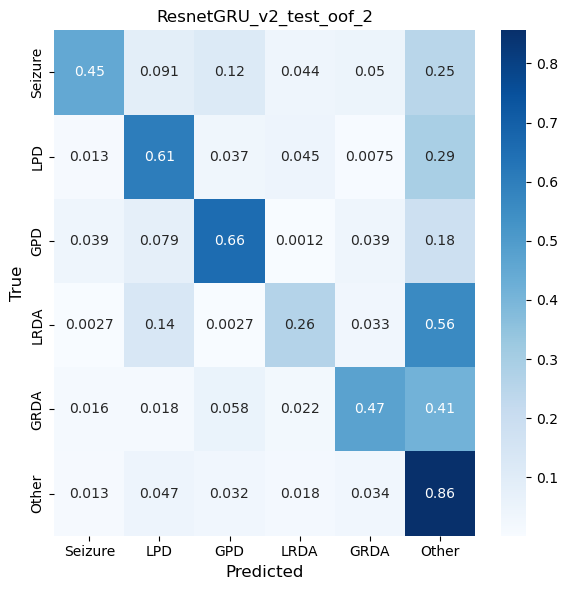

In [5]:
csv_path = f'./outputs/ResnetGRU_v2_test/resnet_vstack_cv040/ResnetGRU_v2_test_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path, select_fold=None)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

pred_entropy = oof_df[TARGETS_PRED].apply(lambda x: entropy(x), axis=1)
print("Average Prediction Entropy: ", pred_entropy.mean())

display(oof_df.head())

print(oof_df.groupby(['target'])['kl_loss'].mean())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

Average KL loss

Reg=0.10
GPD        0.690402
GRDA       0.808140
LPD        0.792532
LRDA       1.289242
Other      0.584849
Seizure    1.180930

Reg=0.05
GPD        0.595413
GRDA       0.835554
LPD        0.867681
LRDA       1.312258
Other      0.495525
Seizure    1.111998

Reg=0.00
GPD        0.587408
GRDA       0.826914
LPD        0.862832
LRDA       1.369003
Other      0.468457
Seizure    1.163169

In [ ]:
csv_path = './outputs/ResnetGRU_v2_test/resnet_vstack_cv040/ResnetGRU_v2_test_oof_1.csv'
print("CSV Path: ", csv_path)

oof_df_1 = analyze_oof(csv_path, select_fold=None)

csv_path = f'./outputs/ResnetGRU_v2_test/resnet_vstack_cv040/ResnetGRU_v2_test_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df_2 = analyze_oof(csv_path, select_fold=None)

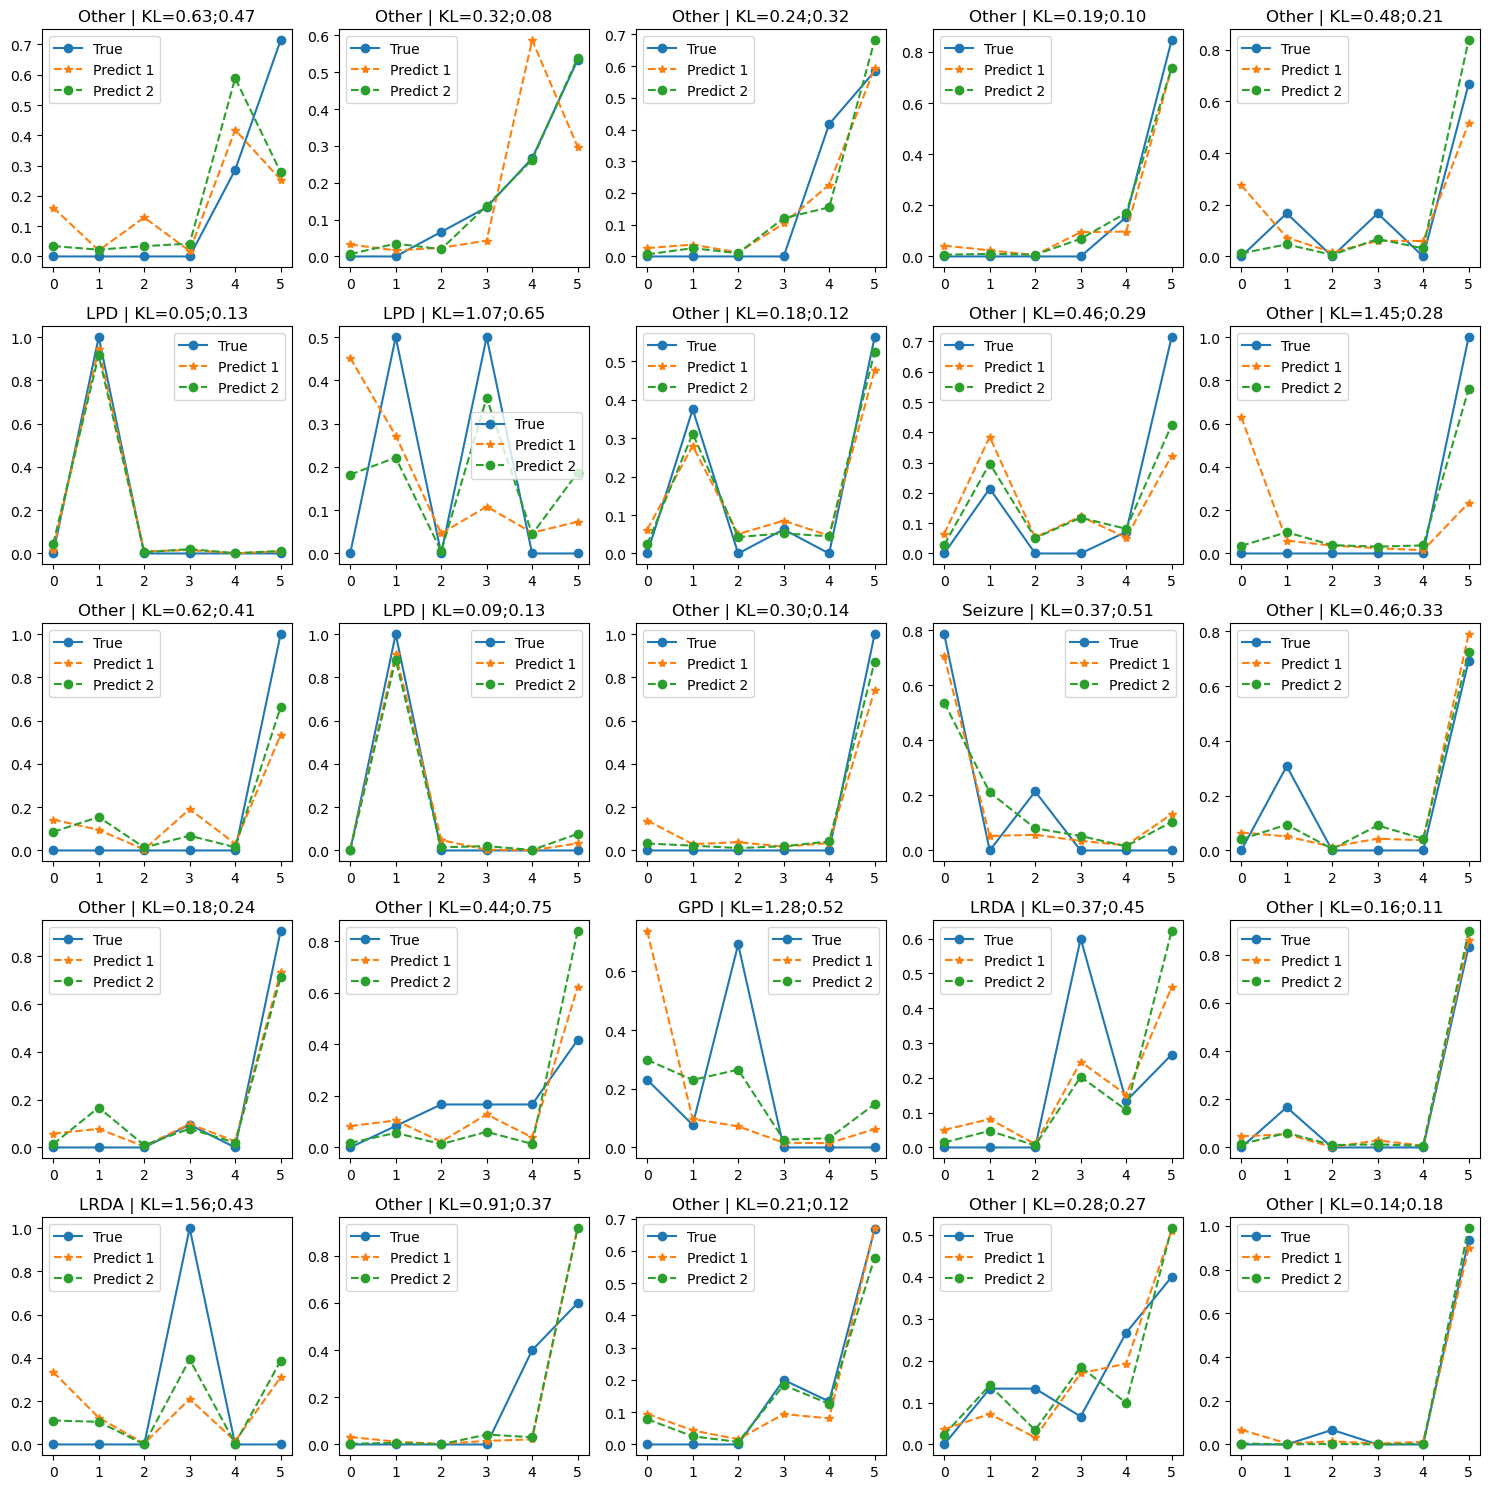

In [13]:
eeg_ids = oof_df_2['eeg_id'].sample(25).values

fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()):
    row_1 = oof_df_1[oof_df_1['eeg_id']==eeg_ids[i]].iloc[0]
    row_2 = oof_df_2[oof_df_2['eeg_id']==eeg_ids[i]].iloc[0]
    x = np.arange(6)
    ax.plot(x, row_1[TARGETS].T, marker="o", ls="-", label="True")
    ax.plot(x, row_1[TARGETS_PRED].T, marker="*", ls="--", label="Predict 1")
    ax.plot(x, row_2[TARGETS_PRED].T, marker="o", ls="--", label="Predict 2")

    target_value = row_1['target'] 
    kl_1 = row_1['kl_loss'] 
    kl_2 = row_2['kl_loss'] 
    ax.set_title(f"{target_value} | KL={kl_1:.2f};{kl_2:.2f}")
    ax.legend()
    
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_samples.png")
plt.show()